# Spell Checking in Ranker

## Misspell Frequency

How many words in a given corpus contain spelling mistakes?

To answer this question, let's create a class that detects misspelled words. This spell checker will be simple. A word will be considered misspelled if it doesn't appear in our dictionary. Our dictionary will be the union of two sets: an English dictionary and a domain-specific dictionary. The domain-specific dictionary will be formed by tokenizing solutions. This implementation relies on the assumption that misspellings in solutions will be uncommon.

In [100]:
import string

import nltk
from nltk.corpus import words
from nltk.stem.porter import PorterStemmer

from common.helper import get_training_files, get_bodies
from common.utils import safe_divide
from common.training_files import Type

COMMON_ACRONYMS = {'ASAP', 'TBD', 'FYI', 'HR', 'ETA', 'EST', 'PST', 'CST', 'UTC'}


class SpellChecker(object):

    def __init__(self):
        self.lexicon = set()
        self.stemmer = PorterStemmer()

        for word in find_english_words() | COMMON_ACRONYMS:
            self.learn_word(word)

    def is_misspelled(self, word):
        word = self.clean_word(word)
        return word.isalpha() and word not in self.lexicon

    def learn_word(self, word):
        self.lexicon.add(self.clean_word(word))

    def learn_words(self, text):
        for word in nltk.word_tokenize(text):
            self.learn_word(word)

    def clean_word(self, word):
        word = word.lower()
        word = word.strip(string.punctuation)
        return self.stemmer.stem(word)

    @staticmethod
    def build(corpora):
        spell_checker = SpellChecker()
        for document in corpora:
            spell_checker.learn_words(document)
        return spell_checker


def find_english_words():
    nltk.download('words')
    return set(words.words())

Let's try instantiating the class.

In [89]:
collection_id = 2
queries, documents = get_bodies(collection_id, Type.QUERIES, Type.DOCS)
spell_checker = SpellChecker.build(documents)

[nltk_data] Downloading package words to /nltk_data...
[nltk_data]   Package words is already up-to-date!


In [90]:
spell_checker.is_misspelled('servor')

True

In [91]:
spell_checker.is_misspelled('server')

False

Our spell checker seems to be working well.

Next, let's use the spell checker to determine the number of misspellings in our corpus of queries.

In [93]:
def count_matches(function, iterable):
    count = 0
    for item in iterable:
        if function(item):
            count += 1
    return count

In [95]:
num_queries_with_misspellings = count_matches(lambda query: any(spell_checker.is_misspelled(word)
                                                                for word in nltk.word_tokenize(query)),
                                              queries)
num_queries_with_misspellings / float(len(queries))

0.29111531190926276

So about 30% of queries have at least one misspelling! That's a lot!

In [97]:
words = [word for query in queries for word in nltk.word_tokenize(query)]
misspell_count = count_matches(spell_checker.is_misspelled, words)
misspell_count / float(len(words))

0.012811231074317732

The percentage of individual words that are misspelled is much lower: about 1%.

What do some of these words look like? Here's 15 random ones:

In [99]:
misspellings = {word for word in words if spell_checker.is_misspelled(word)}
list(misspellings)[:15]

[u'perfrom',
 u'redployed',
 u'consequentive',
 u'ddupDQW',
 u'Hallo',
 u'EMEA',
 u'DiskCapControl',
 u'TAMJIDI',
 u'appilance',
 u'webinterface',
 u'anactive',
 u'migratoin',
 u'BR',
 u'OmniJoin',
 u'bbyvcenter']

## TF-IDF Analysis

How much do these misspellings affect Ranker's performance? Let perform TF-IDF analysis on these misspellings.

First, we'll need to slightly improve our spell checker. We need to add a method that finds the correction for a word. Some of this code is taken from Peter Norvig's [spell checker](http://norvig.com/spell-correct.html).

In [103]:
from collections import Counter

class SpellChecker(object):

    def __init__(self):
        self.lexicon = set()
        self.stemmer = PorterStemmer()
        self.counts = Counter()
        self.number_of_words_in_training = 0

        for word in find_english_words() | COMMON_ACRONYMS:
            self.learn_word(word)

    def is_correct(self, word):
        word = self.clean_word(word)
        return not word.isalpha() or word in self.lexicon

    def is_all_correct(self, text):
        return all(self.is_correct(word) for word in nltk.word_tokenize(text))

    def correct(self, word):
        return max(self.candidates(word), key=self.find_frequency)

    def candidates(self, word):
        return self.known([word]) or self.known(edits1(word)) or self.known(edits2(word)) or [word]

    def known(self, words):
        return {word for word in words if self.is_correct(word)}

    def find_frequency(self, word):
        return safe_divide(self.counts[word], self.number_of_words_in_training)

    def learn_word(self, word):
        self.lexicon.add(self.clean_word(word))

    def learn_words(self, text):
        for word in nltk.word_tokenize(text):
            self.counts[word] += 1
            self.learn_word(word)
        # Lastly, cache training length to improve performance.
        self.number_of_words_in_training = sum(self.counts.values())

    def clean_word(self, word):
        word = word.lower()
        word = word.strip(string.punctuation)
        return self.stemmer.stem(word)

    @staticmethod
    def generate_from_documents(collection_id):
        spell_checker = SpellChecker()
        for document in get_bodies(collection_id, Type.DOCS):
            spell_checker.learn_words(document)
        return spell_checker


def edits1(word):
    """All edits that are one edit away from `word`. Taken from Peter Norvig:
    http://norvig.com/spell-correct.html.
    """
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    """All edits that are two edits away from `word`."""
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

Let's give word correction a go!

In [2]:
spell_checker = SpellChecker.generate_from_documents(collection_id)

[nltk_data] Downloading package words to /nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [3]:
spell_checker.correct('servor')

'server'

Great! We managed to find the right spelling.

Next, let's create a class that finds TF-IDF values.

In [105]:
import math

LOG_BASE = 10

def tokenize(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word.lower().strip(string.punctuation))
            for word in nltk.word_tokenize(text)]

class TFIDF(object):

    def __init__(self):
        self.id_to_counts = {}

    def load(self, document_id, document_text):
        words = tokenize(document_text)
        self.id_to_counts[document_id] = Counter(words)

    def compute(self, word, document_id):
        return self.term_frequency(word, document_id) * self.inverse_document_frequency(word)
        
    def term_frequency(self, word, document_id):
        counts = self.id_to_counts[document_id]
        return safe_divide(counts[word], sum(counts.values()))

    def inverse_document_frequency(self, word):
        n_documents = len(self.id_to_counts)
        n_documents_with_word = len([counter for counter in self.id_to_counts.values()
                                     if counter[word]])
        divide = safe_divide(n_documents, n_documents_with_word)
        return math.log(divide, LOG_BASE) if divide != 0 else divide

    def get_ids(self):
        return set(self.id_to_counts.keys())


def count_matches(iterable, predicate):
    return len([item for item in iterable if predicate(item)])

Let's give `TFIDF` a go.

In [7]:
tfidf = TFIDF()

In [8]:
tfidf.load('0', 'this is a a sample')
tfidf.load('1', 'this is another another example example example')

In [9]:
tfidf.compute('example', '1')

0.12901285528456333

Lastly, let's create some charts! We'll compare the TF-IDF of correct words to incorrect words.

We need to find the TF-IDF of a word in a specific query. Let's instantiate `TFIDF` for that purpose.

In [ ]:
from common.helper import get_training_files

tfidf = TFIDF(tokenize)
files = get_training_files(collection_id)
for query in files.load(Type.QUERIES):
    tfidf.load(query['id'], query.get('body', ''))

In [74]:
tf_idf_correct = []
tf_idf_misspelled = []
    
spell_checker = SpellChecker.generate_from_documents(collection_id)
for query in files.load(Type.QUERIES):
    for word in nltk.word_tokenize(query.get('body', '')):
        if spell_checker.is_correct(word):
            tf_idf_correct.append(tfidf.compute(word, query['id']))
        else:
            correction = spell_checker.clean_word(spell_checker.correct(word))
            tf_idf_misspelled.append(tfidf.compute(correction, query['id']))

In [76]:
len(tf_idf_correct)

219096

In [77]:
len(tf_idf_misspelled)

1284

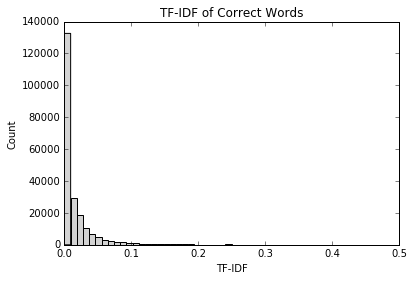

In [83]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.hist(tf_idf_correct, color='lightgrey', bins=400)
ax.set_xlim(xmin=0, xmax=0.5)
plt.xlabel('TF-IDF')
plt.ylabel('Count')
plt.title('TF-IDF of Correct Words')
plt.show()

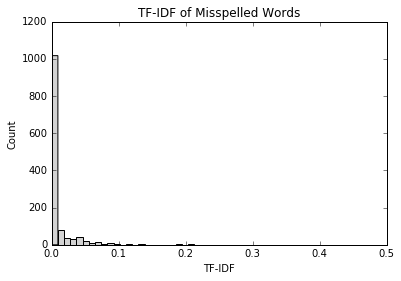

In [80]:
fig, ax = plt.subplots(1,1)
ax.hist(tf_idf_misspelled, color='lightgrey', bins=50)
ax.set_xlim(xmin=0, xmax=0.5)
plt.xlabel('TF-IDF')
plt.ylabel('Count')
plt.title('TF-IDF of Misspelled Words')
plt.show()

Users tend to misspell words with lower TF-IDF values. This likely means that we don't need to worry too much about these misspellings.

In [84]:
misspellings

[u'completly',
 u'throught',
 u'altert',
 u'Installlation',
 u'inacessible',
 u'espress',
 u'HCS',
 u'issuses',
 u'APJ',
 u'steate',
 u'shuting',
 u'Datatsore',
 u'afetr',
 u'Neaz',
 u'Chowdhury',
 u'TBH',
 u'Pranav',
 u'Tushar',
 u'Pawar',
 u'vHost',
 u'avaialble',
 u'hsot',
 u'quickbooks',
 u'Critifcal',
 u'Cust',
 u'vCneter',
 u'Mendoza',
 u'hrtimer',
 u'interoperatbility',
 u'Sharepoint',
 u'vDistributed',
 u'VmfsSparseExtentCombine',
 u'SnapshotVMXCombineFinalCb',
 u'usec',
 u'purpple',
 u':InitialProtectedList',
 u':InitialProtectedList',
 u'EXSI',
 u'discoonection',
 u'aroun',
 u'kinldy',
 u'connectivy',
 u'liaise',
 u'galunggung',
 u'papandayan',
 u'mroe',
 u'srea',
 u'afected',
 u'SKVHOUS',
 u'VNXe',
 u'Dandrea',
 u'fberchannel',
 u'Unfortuantely',
 u'dereference',
 u'deanlewis',
 u'Canopius',
 u'kinda',
 u'recoring',
 u'examaning',
 u'Audodeploy',
 u'DumpCollector',
 u'AuthenticationProxy',
 u'assitance',
 u'DFR',
 u'VPID',
 u'VPID',
 u'uild',
 u'Vcnter',
 u'balve',
 u'LDN',
